In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score,log_loss

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

In [7]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)

In [8]:
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))

## 데이터 라벨 구조 보기

<Figure size 864x720 with 0 Axes>

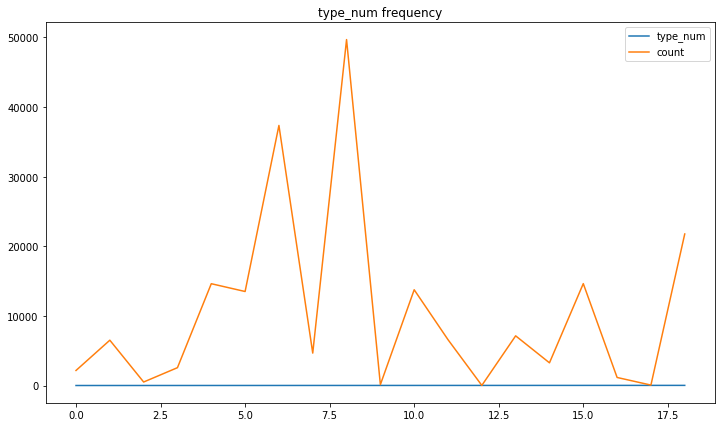

In [9]:
grouped_type_num = train.groupby("type_num", sort='count').size().reset_index(name='count')
fig = plt.figure(figsize=(12,10))
grouped_type_num.plot(figsize=(12,7), title="type_num frequency")

In [11]:
train_x = train.drop(columns=['type', 'type_num'], axis=1)
train_y = train['type_num']
test_x = test

In [12]:
print(train_x.isnull().any().sum())
print(train_y.isnull().any().sum())
print(test_x.isnull().any().sum())

0
0
0


In [13]:
train_x.columns

Index(['fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z',
       'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z',
       'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z'],
      dtype='object')

C:\Users\realna\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


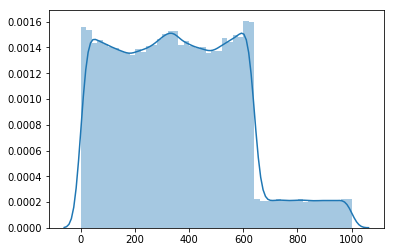

In [14]:
# distribution of Amount
amount = [train_x['fiberID'].values]
sns.distplot(amount)

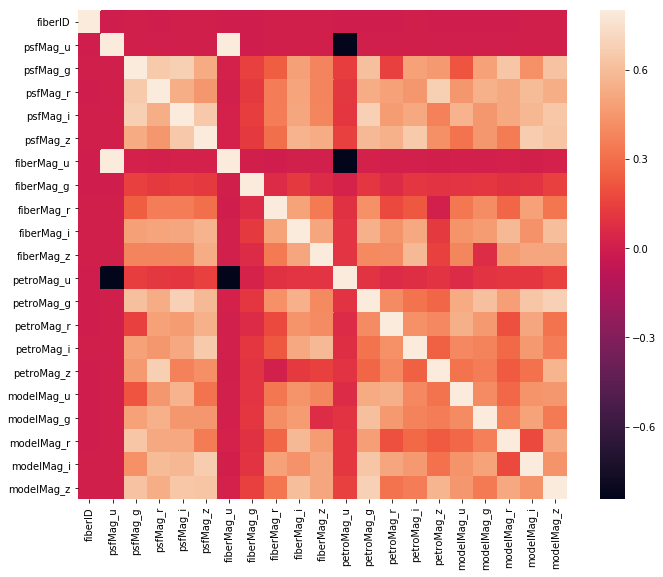

In [15]:
# heat map of correlation of features
correlation_matrix = train_x.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

In [16]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(train_x.values)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
finalDf = pd.concat([principalDf, train_y], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,type_num
0,-32.078987,4.126174,9.034291,8
1,-30.247245,3.279877,7.434948,8
2,-25.813486,-2.756650,-4.727174,8
3,-29.419875,2.172165,5.053226,8
4,-36.001919,6.099129,10.687132,10


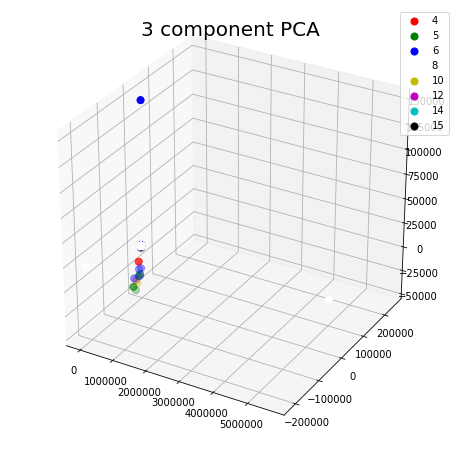

In [17]:
# 2D visualization
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (8,8))
#ax = fig.add_subplot(1,1,1) 
ax = fig.gca(projection='3d')
ax.set_title('3 component PCA', fontsize = 20)
targets = [4,5,6,8,10,12,14,15,22]
colors = ['r', 'g','b','w','y','m','c','k']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['type_num'] == target
    ax.scatter3D(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

C:\Users\realna\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


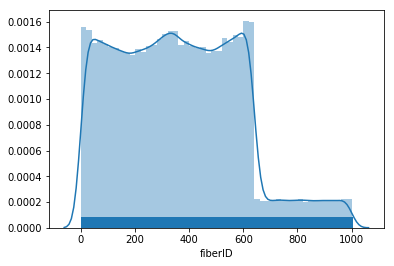

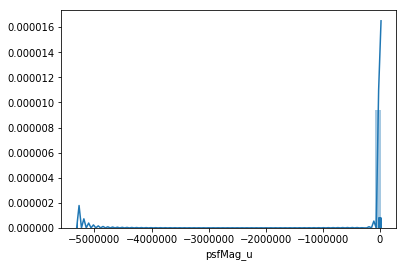

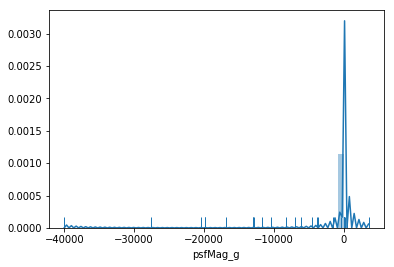

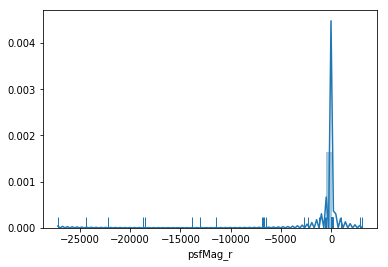

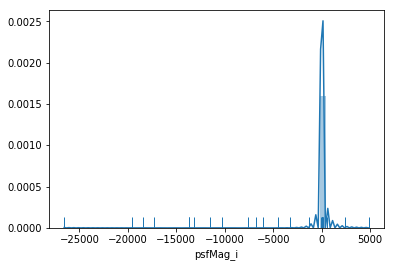

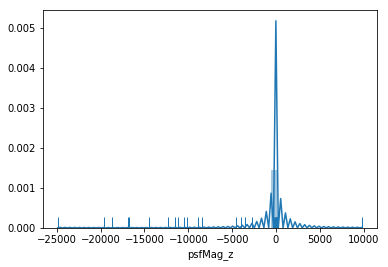

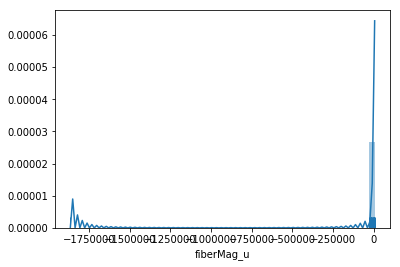

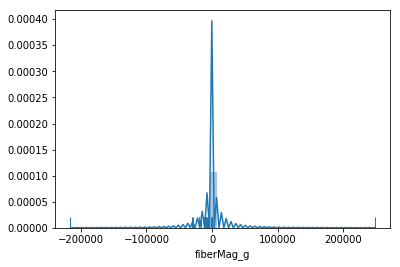

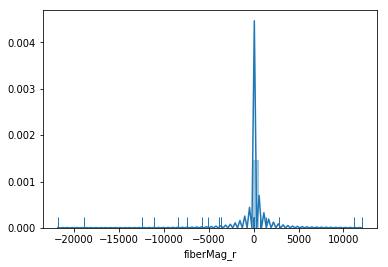

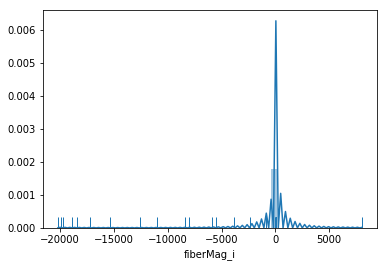

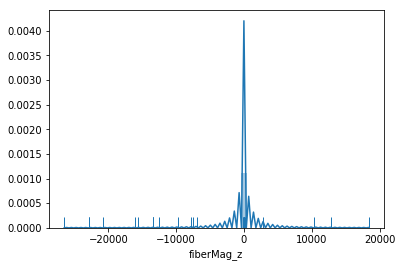

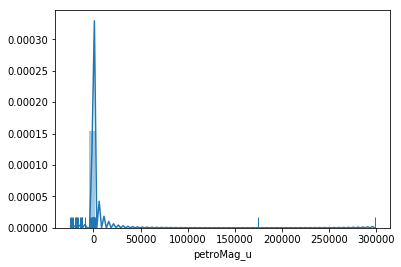

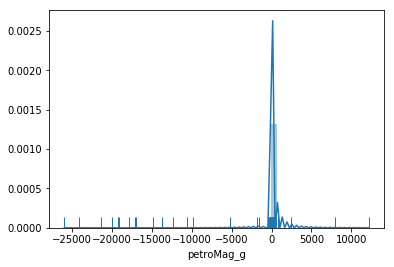

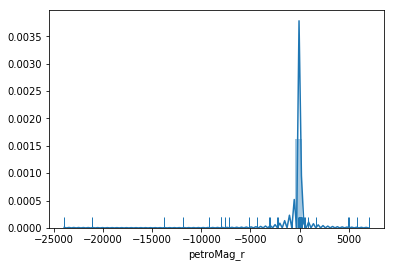

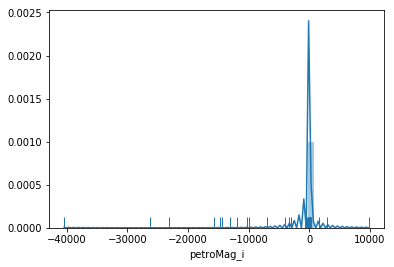

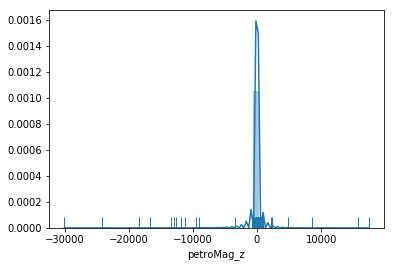

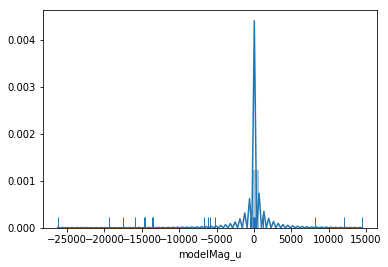

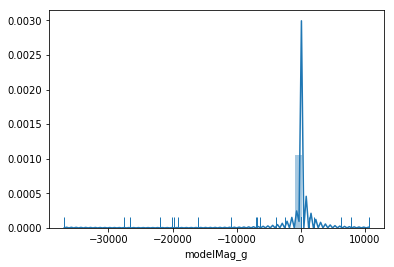

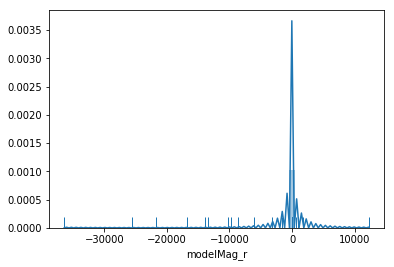

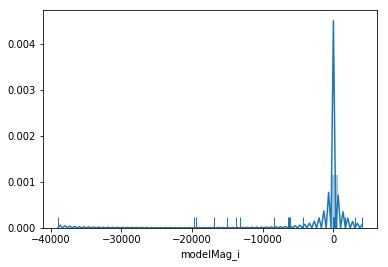

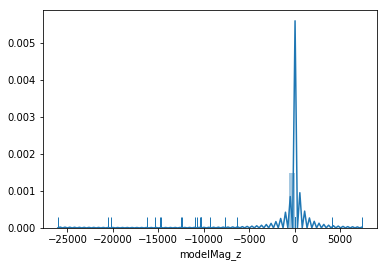

In [18]:
for col in train_x.columns:
    sns.distplot(train_x[col], kde=True, rug=True)
    plt.show()
#sns.distplot(train_x["psfMag_u"], kde=True, rug=True)
#plt.legend(title="Columns")


In [19]:
train_x["psfMag_u"].min()

-5310801.77091916

In [20]:
robust_train_x = RobustScaler().fit_transform(train_x)

In [21]:
df_robust_train_x = pd.DataFrame(robust_train_x,columns=train_x.columns)

C:\Users\realna\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


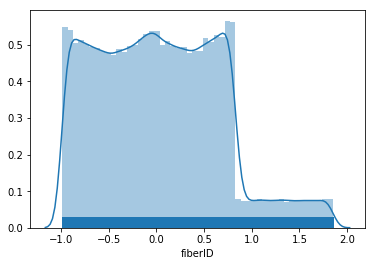

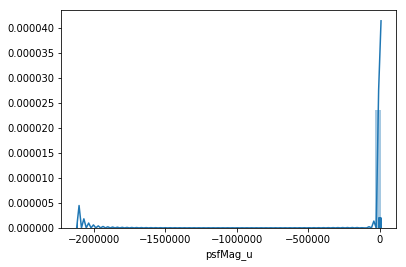

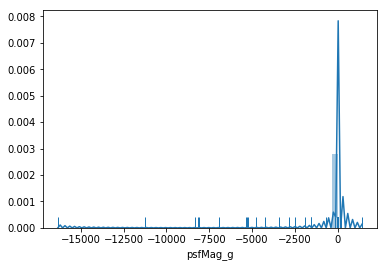

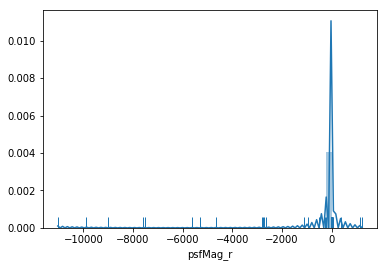

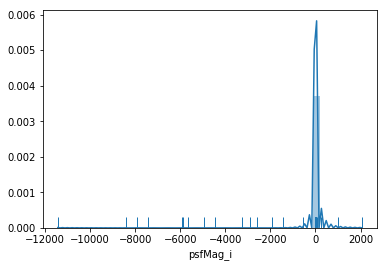

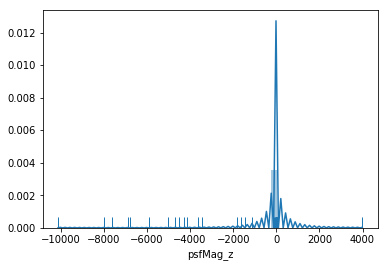

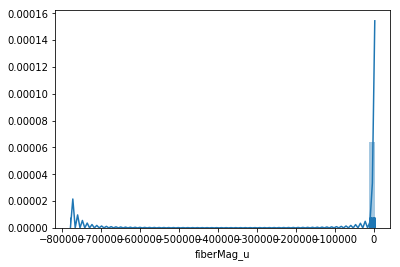

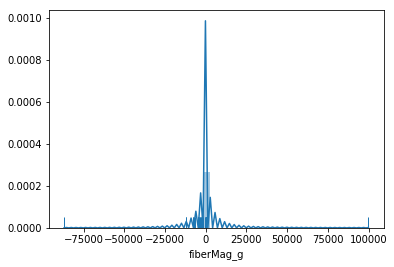

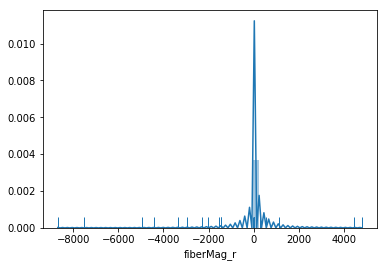

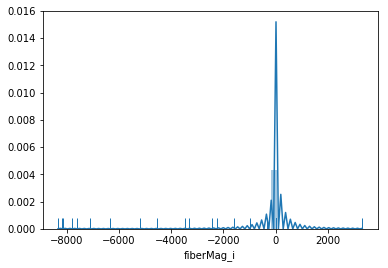

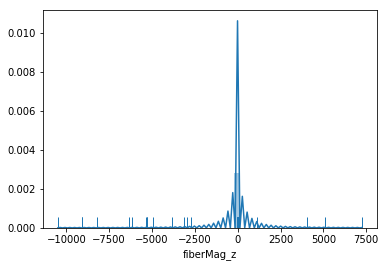

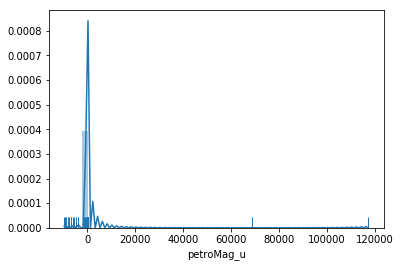

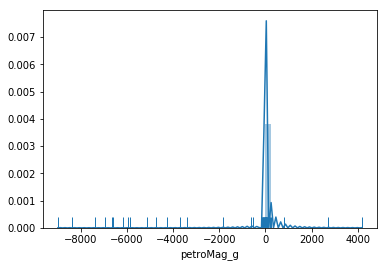

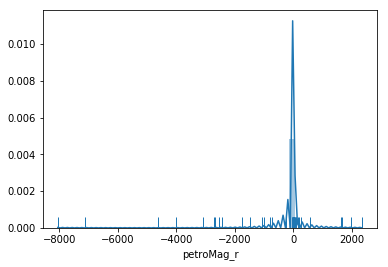

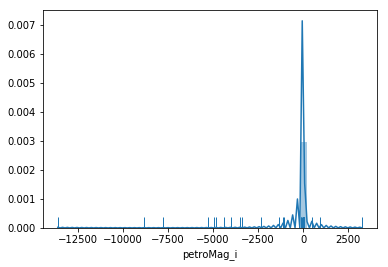

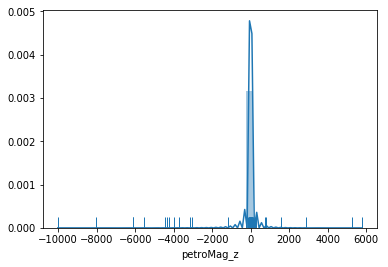

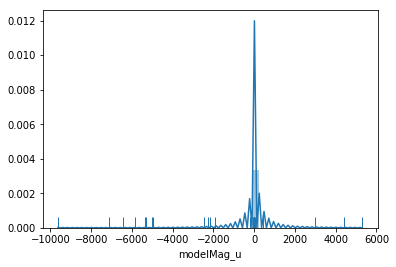

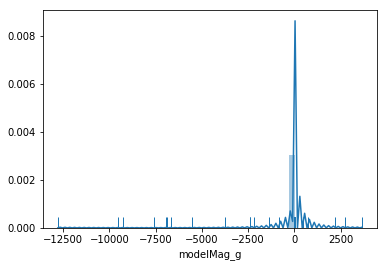

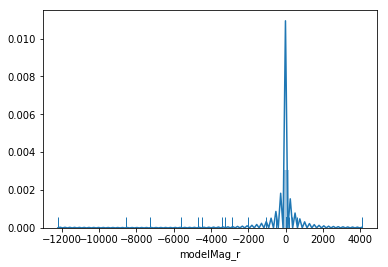

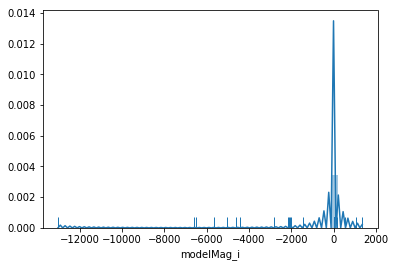

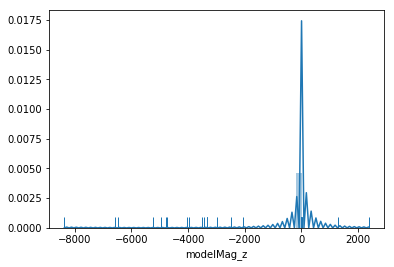

In [22]:
for col in df_robust_train_x.columns:
    sns.distplot(df_robust_train_x[col], kde=True, rug=True)
    plt.show()

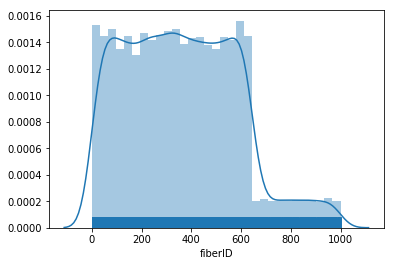

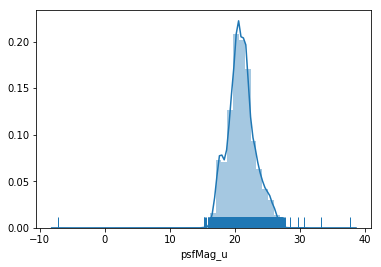

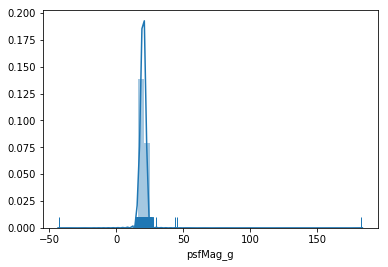

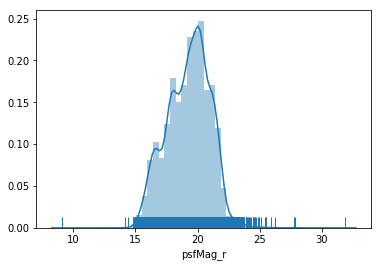

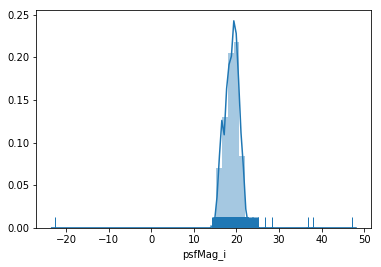

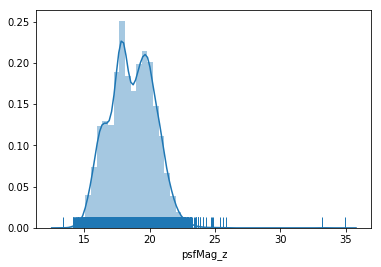

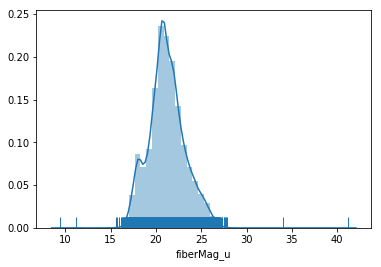

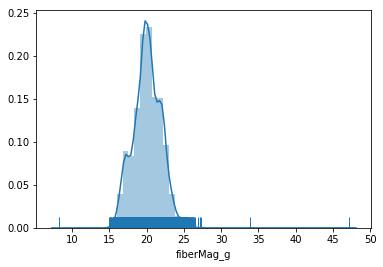

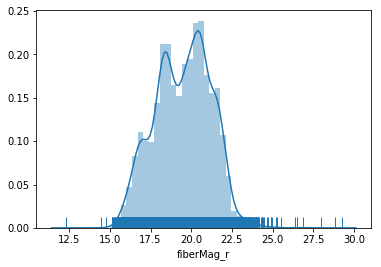

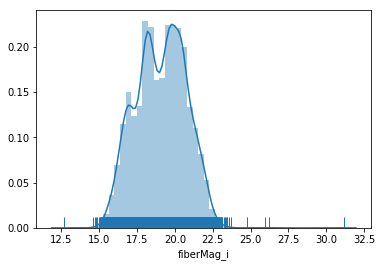

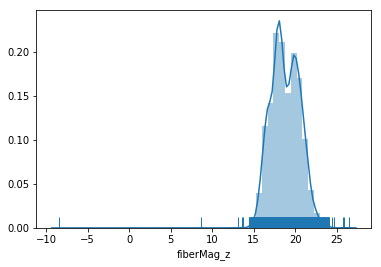

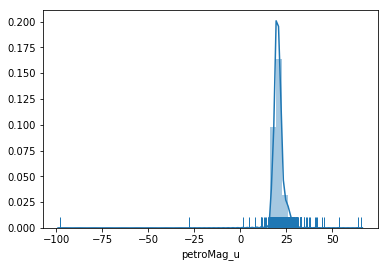

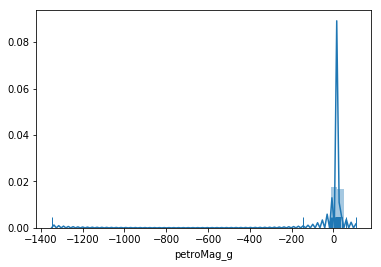

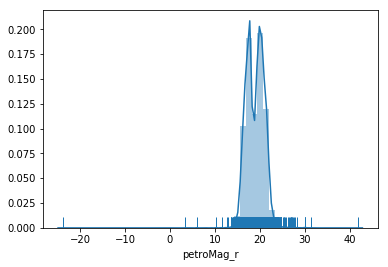

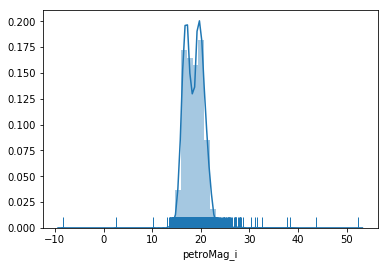

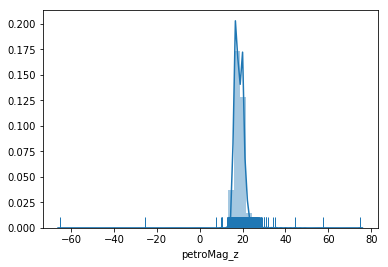

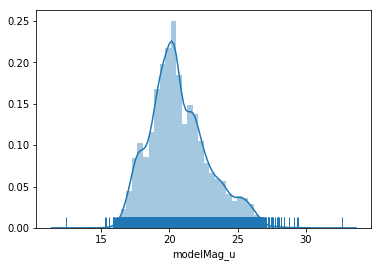

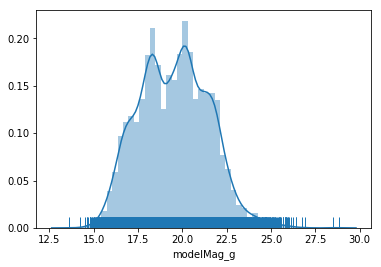

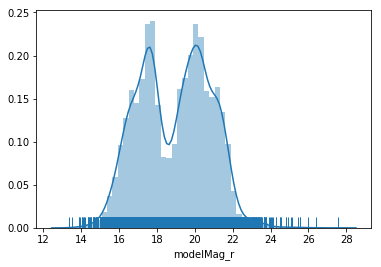

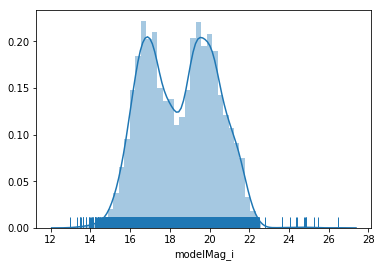

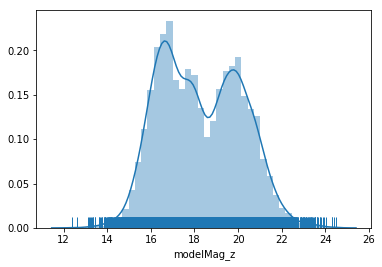

In [23]:
for col in test.columns:
    sns.distplot(test[col], kde=True, rug=True)
    plt.show()

In [24]:
robust_test_x = RobustScaler().fit_transform(test_x)

In [25]:
df_robust_test_x = pd.DataFrame(robust_test_x,columns=test_x.columns)

In [49]:
#clf = RandomForestClassifier(n_estimators=1500)
#clf = ExtraTreesClassifier(n_estimators=1500)
clf = XGBClassifier(n_estimators=50)
#clf = LGBMClassifier()
clf.fit(df_robust_train_x[:180000], train_y[:180000])
clf_probs = clf.predict_proba(df_robust_train_x[180000:])
score = log_loss(train_y[180000:], clf_probs)
print(score)

0.5822110283755719


In [47]:
#clf = RandomForestClassifier(n_estimators=1500)
#clf = ExtraTreesClassifier(n_estimators=1500)
#clf = XGBClassifier()
lgbm_clf = LGBMClassifier(n_estimators=27)
lgbm_clf.fit(df_robust_train_x[:180000], train_y[:180000])
lgbm_clf_probs = lgbm_clf.predict_proba(df_robust_train_x[180000:])
score = log_loss(train_y[180000:], lgbm_clf_probs)
print(score)

0.6656085102180104


In [36]:
lgbm_clf

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [31]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [ ]:
#Extra 0.36995435209493194


In [21]:
#로버스트 정규화 데이터
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest.fit(df_robust_train_x, train_y)
y_pred = forest.predict_proba(df_robust_test_x)
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission4_n1500_extra.csv', index=True)